In [1]:
import sys
from pathlib import Path

parent_dir = Path.cwd().parent.parent
sys.path.append(str(parent_dir))

In [2]:
import numpy as np
import cv2
import dlib
from data_processing.image_processing import ImageProcessor
global_detector = dlib.get_frontal_face_detector()
global_predictor = dlib.shape_predictor('../shape_predictor_68_face_landmarks.dat')
global_sr_model = cv2.dnn_superres.DnnSuperResImpl_create()
global_sr_model.readModel("../EDSR_x4.pb")
global_sr_model.setModel("edsr", 2)
ImageProcessor = ImageProcessor(global_detector, global_predictor, global_sr_model)

In [3]:
def get_combined_eyes(frame, global_sr_model, global_detector, global_predictor, target_size=(40, 48)):
    """
    Detects, enhances, and combines the eye regions from the frame using the extract_eye_region method.
    Args:
        frame: The input image frame.
        global_sr_model: Super-resolution model.
        global_detector: Face detector.
        global_predictor: Landmark predictor.
        target_size: Target size for resizing each eye region.
    Returns:
        The combined eye regions, or None if not detected.
    """
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = global_detector(gray)

    for face in faces:
        landmarks = global_predictor(gray, face)

        left_eye_points = [36, 37, 38, 39, 40, 41]
        right_eye_points = [42, 43, 44, 45, 46, 47]

        # Preprocess each eye region
        left_eye_region, _ = ImageProcessor.extract_eye_region(frame, landmarks, left_eye_points)
        right_eye_region, _ = ImageProcessor.extract_eye_region(frame, landmarks, right_eye_points)

        # Enhance image resolution and normalize
        left_eye_super_res = ImageProcessor.enhance_image_resolution(left_eye_region, global_sr_model).astype(np.float32) / 255.0
        right_eye_super_res = ImageProcessor.enhance_image_resolution(right_eye_region, global_sr_model).astype(np.float32) / 255.0

        # Resize images to the target size
        left_eye_resized = cv2.resize(left_eye_super_res, target_size, interpolation=cv2.INTER_AREA)
        right_eye_resized = cv2.resize(right_eye_super_res, target_size, interpolation=cv2.INTER_AREA)

        # Combine the eyes side by side
        combined_eyes = np.hstack([left_eye_resized, right_eye_resized])
        
        return combined_eyes

    return None

In [4]:

def normalize_head_pose(head_pose_data, rotation_scale=180, translation_max_displacement=None):
    """
    Normalizes the head pose data.
    Args:
        head_pose_data: List containing the head pose data (rotation and translation vectors).
        rotation_scale: Maximum value for the rotation vector components (180 for degrees, np.pi for radians).
        translation_max_displacement: A tuple (max_x, max_y, max_z) representing the maximum displacement in each axis. If None, standard deviation normalization will be used.

    Returns:
        Normalized head pose data.
    """
    # Normalize rotation vectors
    normalized_rotation = np.array(head_pose_data[:3]) / rotation_scale

    # Normalize translation vectors
    if translation_max_displacement:
        max_x, max_y, max_z = translation_max_displacement
        normalized_translation = np.array(head_pose_data[3:]) / np.array([max_x, max_y, max_z])
    else:
        # Standard deviation normalization
        translation_vector = np.array(head_pose_data[3:])
        std_dev = np.std(translation_vector)
        mean_val = np.mean(translation_vector)
        normalized_translation = (translation_vector - mean_val) / std_dev

    return np.concatenate([normalized_rotation, normalized_translation]).tolist()

In [5]:
#load the model
from keras.models import load_model
model = load_model('../models/eye_gaze_v17.h5')

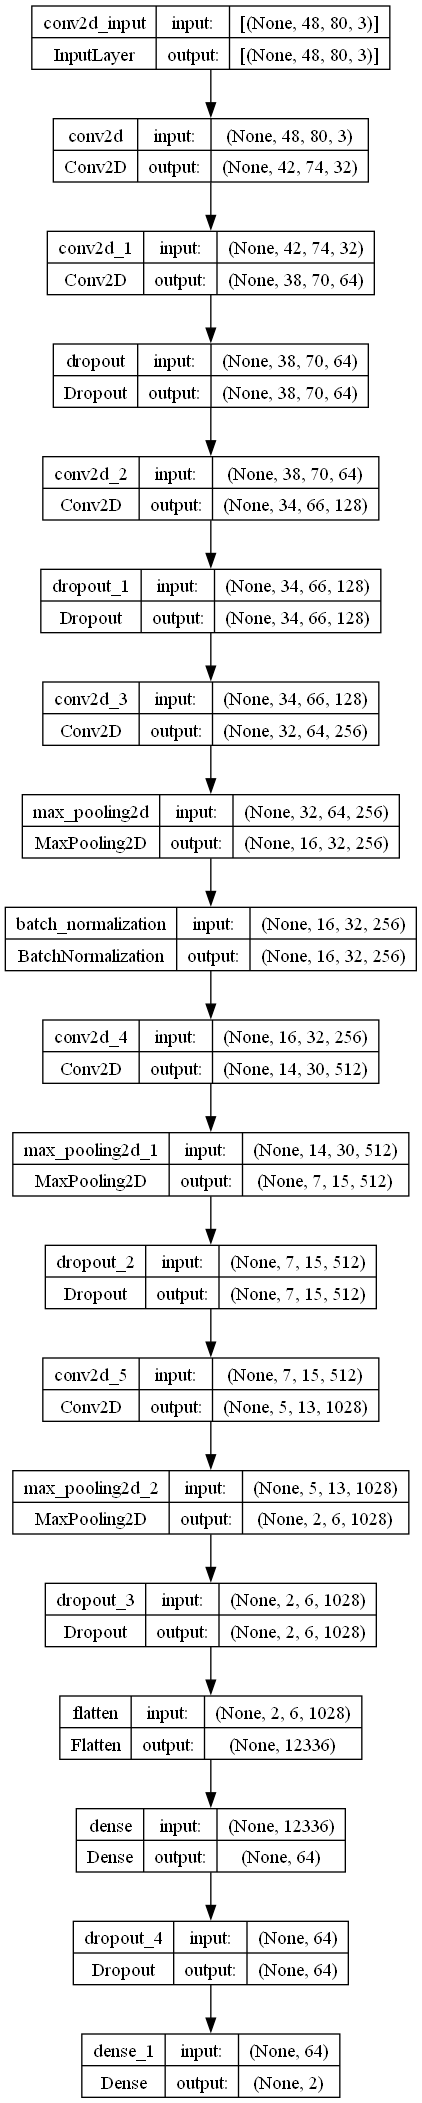

In [6]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [ ]:
import cv2
import numpy as np
from collections import deque

# Initialize a queue to store gaze points (Change the number of points as needed)
n_points = 5
gaze_points_queue = deque(maxlen=n_points)

# Screen dimensions
screenWidth = 1707
screenHeight = 960

def moving_average(new_point, queue):
    queue.append(new_point)
    return [sum(x) / len(queue) for x in zip(*queue)]

cap = cv2.VideoCapture(0)
cv2.namedWindow('Gaze Tracking on Canvas', cv2.WINDOW_NORMAL)
cv2.setWindowProperty('Gaze Tracking on Canvas', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

# Assuming screenHeight and screenWidth are defined
canvas = np.zeros((screenHeight, screenWidth, 3), dtype=np.uint8)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    combined_eyes = get_combined_eyes(frame, global_sr_model, global_detector, global_predictor)

    if combined_eyes is not None:
        combined_eyes = np.expand_dims(combined_eyes, axis=0)
        predicted_gaze = model.predict(combined_eyes)[0]

        # Scale the prediction to screen size
        gaze_x_scaled = int(predicted_gaze[0] * screenWidth)
        gaze_y_scaled = int(predicted_gaze[1] * screenHeight)

        # Apply moving average filter
        # gaze_x_smooth, gaze_y_smooth = moving_average((gaze_x_scaled, gaze_y_scaled), gaze_points_queue)

        # Clamp to screen size
        gaze_x_scaled = max(0, min(gaze_x_scaled, screenWidth - 1))
        gaze_y_scaled = max(0, min(gaze_y_scaled, screenHeight - 1))

        canvas.fill(0)
        cv2.circle(canvas, (gaze_x_scaled, gaze_y_scaled), 10, (0, 255, 0), -1)
        cv2.imshow('Gaze Tracking on Canvas', canvas)
    else:
        pass

    cv2.imshow('Original Webcam Feed', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
import pandas as pd
import cv2
import numpy as np
import pickle
# Load your main gaze detection model
model = load_model('../models/eye_gaze_v14_sigmoid.h5')

# Load the adjustment model
with open('../adjustment_model.pkl', 'rb') as f:
    adjustment_model = pickle.load(f)

# Read a row from your dataset
row = pd.read_csv('../data/Will/eye_gaze_data.csv').iloc[101]

# Preprocess the image
image_path = f'../{row[0]}'
image = cv2.imread(image_path)
cv2.imshow('Original Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()
# Assuming `get_combined_eyes` is a function you have defined elsewhere
image = get_combined_eyes(image, global_sr_model, global_detector, global_predictor)
image = np.expand_dims(image, axis=0)

# Predict gaze point with the main model
pred = model.predict(image)[0]

# Adjust the prediction using the adjustment model
# Ensure the predicted gaze point is in the correct shape for the adjustment model
pred = pred.reshape(1, -1)  # Reshape if necessary
adjusted_pred = adjustment_model.predict(pred)[0]  # Adjust

# Screen dimensions
screenWidth, screenHeight = 1707, 960

# Canvas for visualization
canvas = np.zeros((screenHeight, screenWidth, 3), dtype=np.uint8)
cv2.namedWindow('Gaze Tracking on Canvas', cv2.WINDOW_NORMAL)
cv2.setWindowProperty('Gaze Tracking on Canvas', cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)

# Actual gaze coordinates from the dataset
real_x, real_y = int(row[1]), int(row[2])
print('real', real_x, real_y)

# Original and adjusted predicted gaze coordinates, scaled to screen size
pred_x, pred_y = pred[0][0], pred[0][1]
pred_x, pred_y = pred_x * screenWidth, pred_y * screenHeight
print('orig_pred', pred_x, pred_y)
adjusted_x, adjusted_y = adjusted_pred[0] * screenWidth, adjusted_pred[1] * screenHeight

# Ensure the coordinates are within screen bounds
pred_x = min(max(int(pred_x), 0), screenWidth)
pred_y = min(max(int(pred_y), 0), screenHeight)

adjusted_x = min(max(int(adjusted_x), 0), screenWidth)
adjusted_y = min(max(int(adjusted_y), 0), screenHeight)
print('adjusted_pred', adjusted_x, adjusted_y)

# Visualization
#Draw the points in different colors
# Red: Actual gaze point
# Green: Original predicted gaze point
# Blue: Adjusted predicted gaze point
cv2.circle(canvas, (real_x, real_y), 10, (0, 0, 255), -1)  # Red circle for actual gaze point
cv2.putText(canvas, 'Actual', (real_x + 20, real_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

cv2.circle(canvas, (pred_x, pred_y), 10, (0, 255, 0), -1)  # Green circle for original predicted gaze point
cv2.putText(canvas, 'Original_pred', (pred_x + 20, pred_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

cv2.circle(canvas, (adjusted_x, adjusted_y), 10, (255, 0, 0), -1)  # Blue circle for adjusted predicted gaze point
cv2.putText(canvas, 'Adjusted', (adjusted_x + 20, adjusted_y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

cv2.imshow('Gaze Tracking on Canvas', canvas)
cv2.waitKey(0)
cv2.destroyAllWindows()